In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset
from generation.train.vanila_gan import run_train, generate_new_signal
from scipy import signal
from sklearn.linear_model import Ridge
import tqdm

In [3]:
# Data params
SAMPLE_SIZE = 50
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.0005

nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

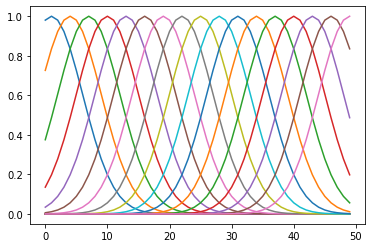

In [4]:
POINTS_NUM = 101
STD = 5

sample = data[0] #np.reshape(data[0], (len(data[0]), 1))
max_loc = np.argmax(signal.gaussian(POINTS_NUM, std=STD))
gaussians = []
for i in range(0, len(sample), 3):
    start_pos = max_loc - i - 1
    end_pos = start_pos + len(sample)
    values = signal.gaussian(POINTS_NUM, std=STD)[start_pos:end_pos]
    plt.plot(values)
    gaussians.append(values)
plt.show()

In [5]:
X = np.array(gaussians).T
y = sample.copy()
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (50, 17)
y shape: (50,)


In [6]:
lr = Ridge(alpha=0.1)
lr.fit(X, y)

result = [lr.intercept_] * len(sample)
for i in range(len(gaussians)):
    result += lr.coef_[i] * gaussians[i]

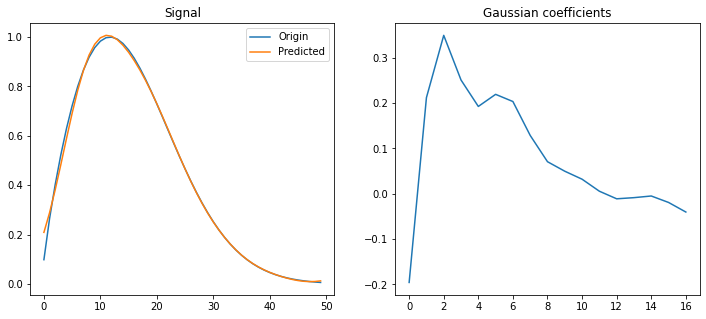

In [7]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Signal")
ax[0].plot(y)
ax[0].plot(result)
ax[0].legend(['Origin', 'Predicted'])
ax[1].set_title("Gaussian coefficients")
ax[1].plot(lr.coef_)
plt.show()

In [8]:
id_to_coef = {i: [] for i in range(len(data))}
id_to_intercept = {i: None for i in range(len(data))}

def transform_data(data, lr_alpha=0.1, std=5, coef=3):
    lr = Ridge(alpha=0.1)
    new_data = []
    for i, sample in enumerate(data):
        points_num = 2*len(sample) + 1
        max_loc = np.argmax(signal.gaussian(points_num, std=std))
        gaussians = []
        for j in range(0, len(sample), coef):
            start_pos = max_loc - j - 1
            end_pos = start_pos + len(sample)
            values = signal.gaussian(points_num, std=std)[start_pos:end_pos]
            gaussians.append(values)
            
        cur_X = np.array(gaussians).T
        cur_y = sample.copy()
        lr.fit(cur_X, cur_y)
        id_to_coef[i] = lr.coef_
        id_to_intercept[i] = lr.intercept_
        new_data.append(lr.coef_)
    return new_data

In [9]:
def back_transform_data(data):
    origin_data = []
    for i, sample in enumerate(data):
        result = [id_to_intercept[i]] * SAMPLE_SIZE
        for j in range(len(gaussians)):
            result += id_to_coef[i][j] * gaussians[j]
        origin_data.append(result)
    return origin_data

In [10]:
new_data = transform_data(data)

In [11]:
LATENT_DIM = 100
BATCH_SIZE = 128
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
PRINT_EACH = 50
VERBOSE = 1
NO_SAVE = True
DEVICE = 'cuda'


dataset = SignalsDataset(new_data)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

epoch-0; D_loss: 1.2490246295928955; G_loss: 0.7088080644607544


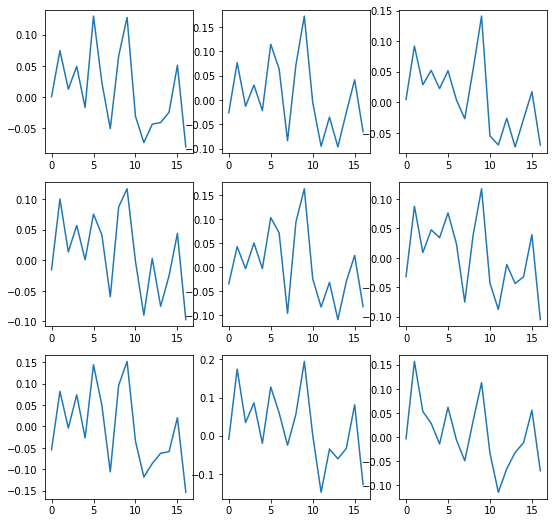

epoch-50; D_loss: 0.04745214805006981; G_loss: 8.414827346801758


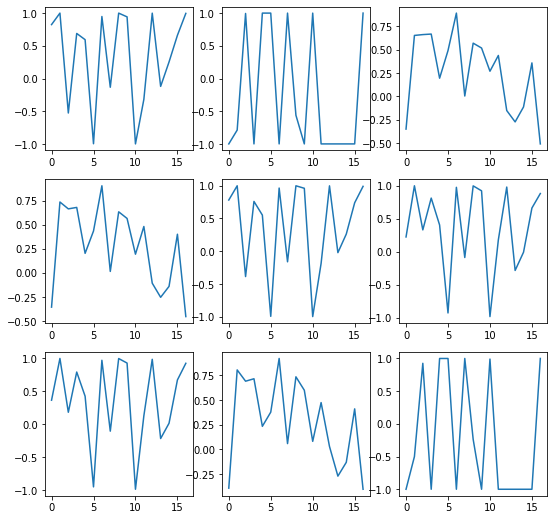

epoch-100; D_loss: 0.5318425297737122; G_loss: 7.907729148864746


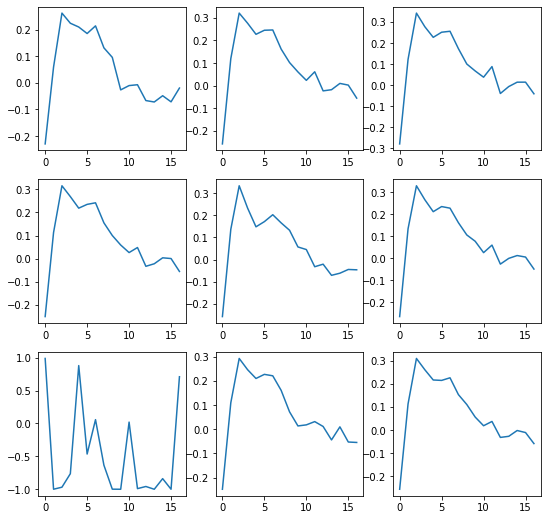

epoch-150; D_loss: 0.8078619837760925; G_loss: 3.233491897583008


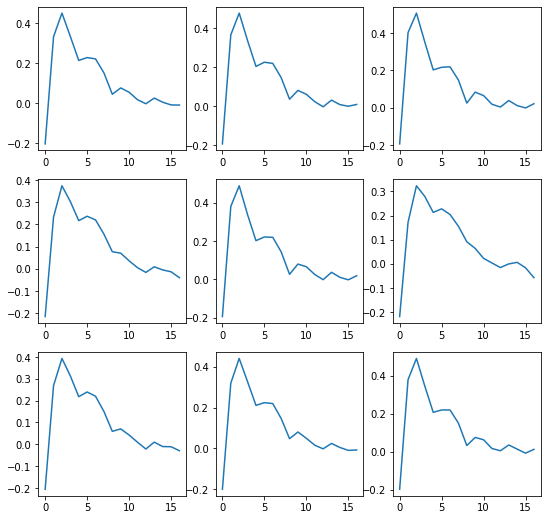

epoch-200; D_loss: 0.8095197677612305; G_loss: 1.5143758058547974


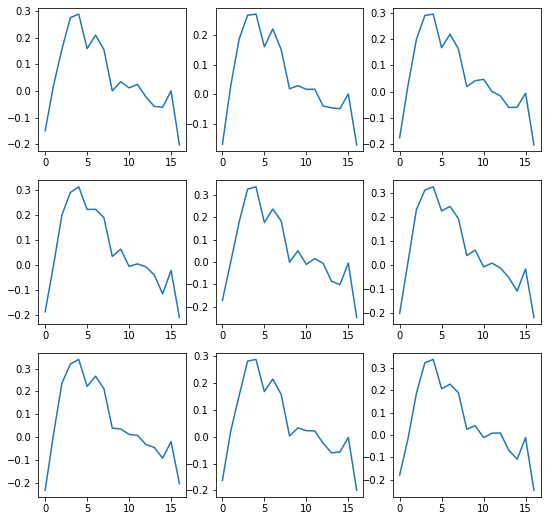

epoch-250; D_loss: 0.7588316202163696; G_loss: 1.4627723693847656


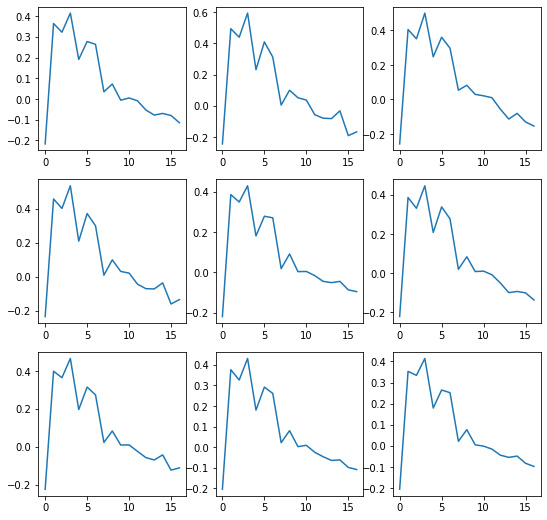

epoch-300; D_loss: 1.9111522436141968; G_loss: 0.6422035098075867


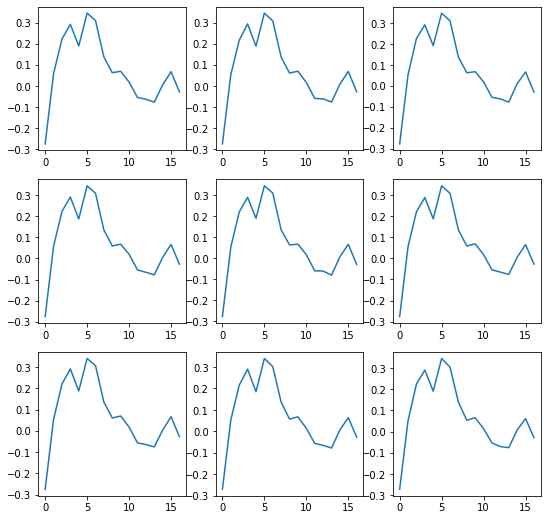

epoch-350; D_loss: 1.4011812210083008; G_loss: 0.7036638259887695


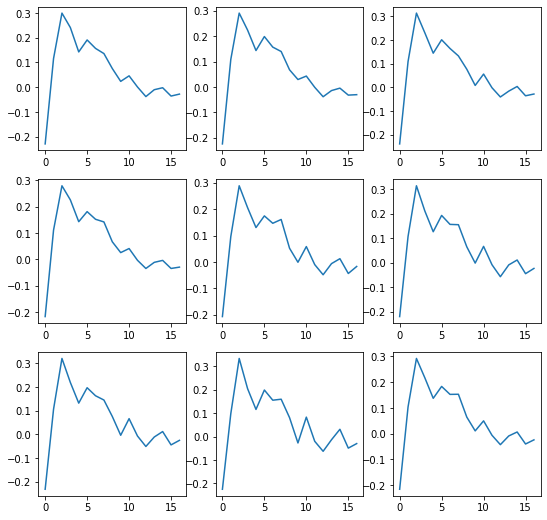

epoch-400; D_loss: 1.8588566780090332; G_loss: 0.5719554424285889


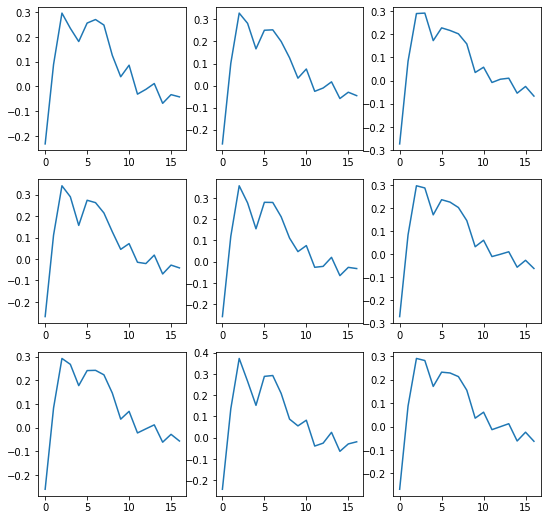

epoch-450; D_loss: 0.974913477897644; G_loss: 0.9159259796142578


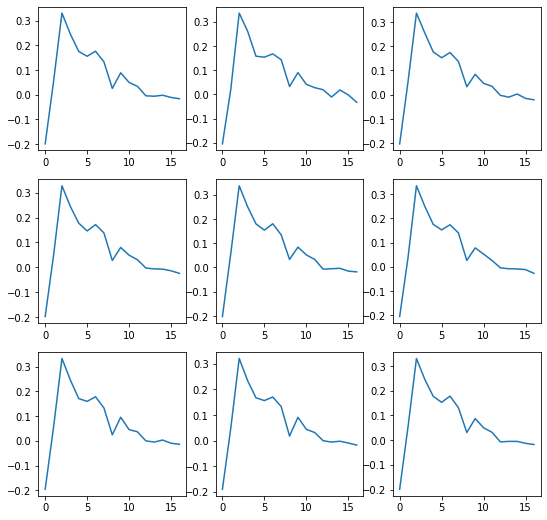

epoch-500; D_loss: 1.446767807006836; G_loss: 0.6647272109985352


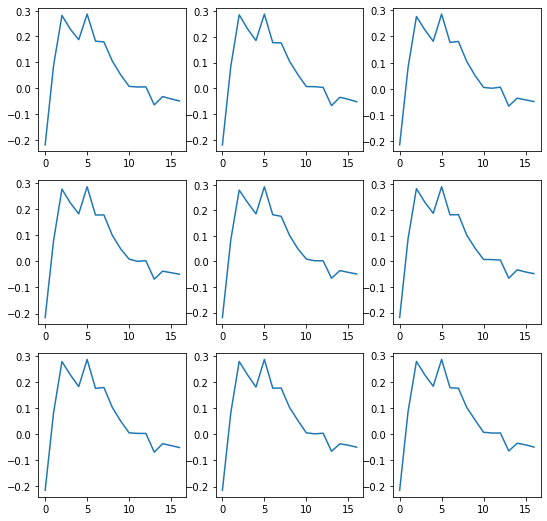

epoch-550; D_loss: 1.4083030223846436; G_loss: 0.6700795888900757


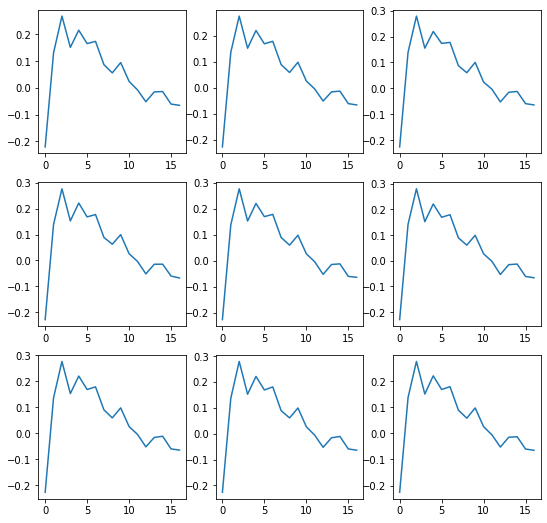

epoch-600; D_loss: 1.2134368419647217; G_loss: 0.8088591694831848


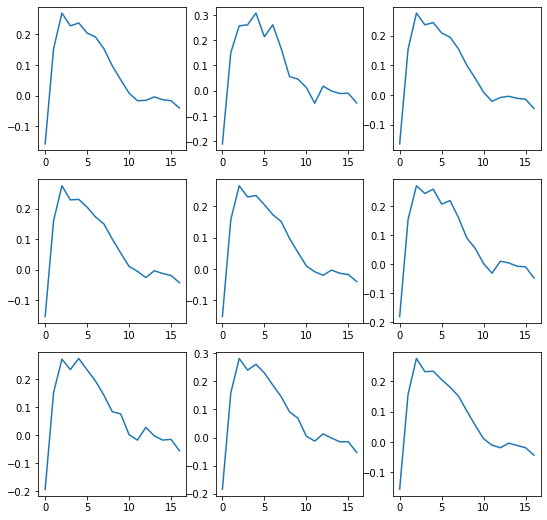

epoch-650; D_loss: 1.4176526069641113; G_loss: 0.6779330968856812


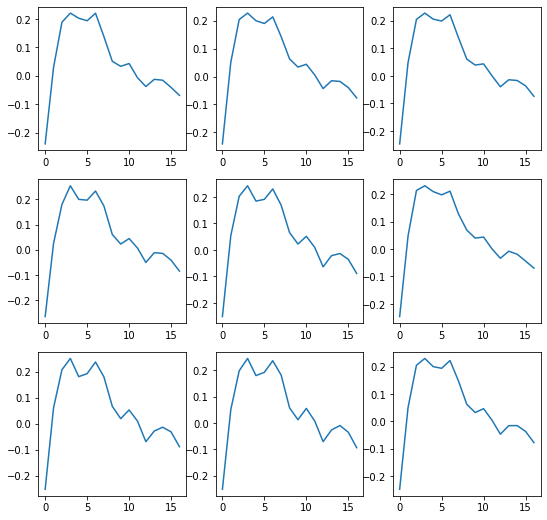

epoch-700; D_loss: 1.2469685077667236; G_loss: 0.7664395570755005


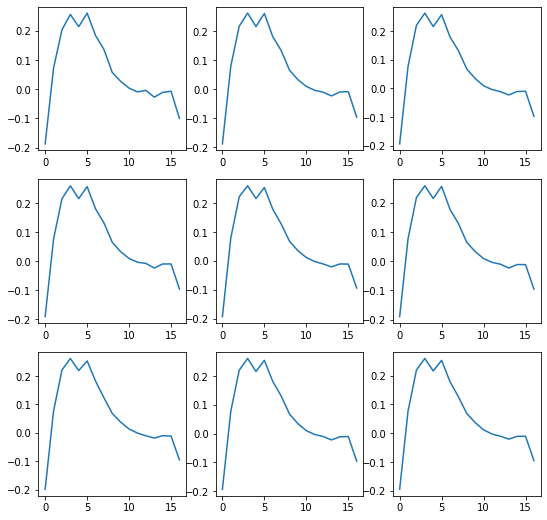

epoch-750; D_loss: 1.5312509536743164; G_loss: 0.6572276949882507


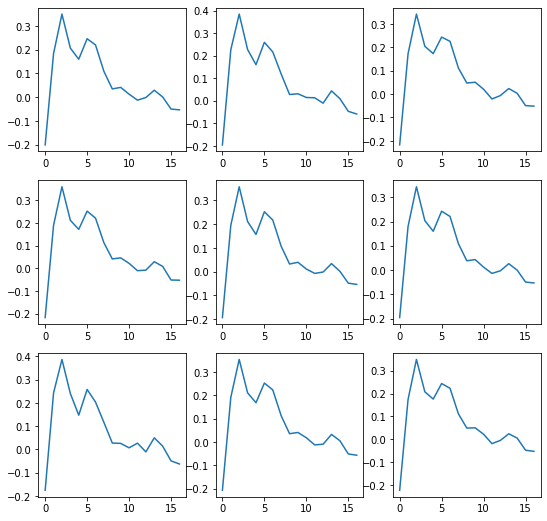

epoch-800; D_loss: 1.3596802949905396; G_loss: 0.706006646156311


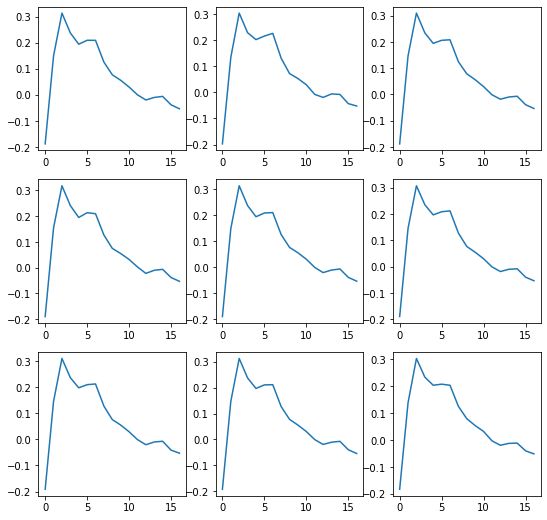

epoch-850; D_loss: 1.3868558406829834; G_loss: 0.7025817036628723


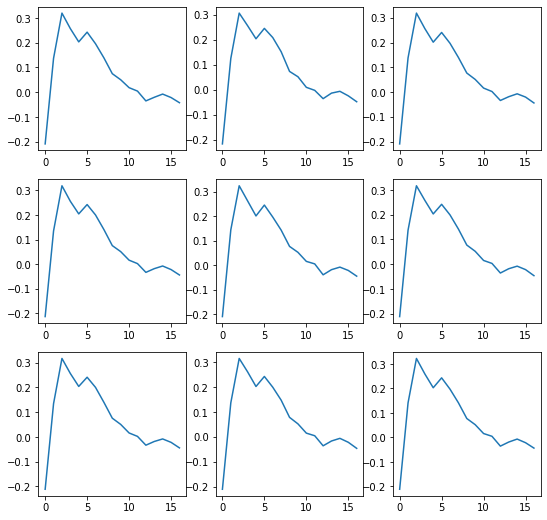

epoch-900; D_loss: 1.432982325553894; G_loss: 0.6688542366027832


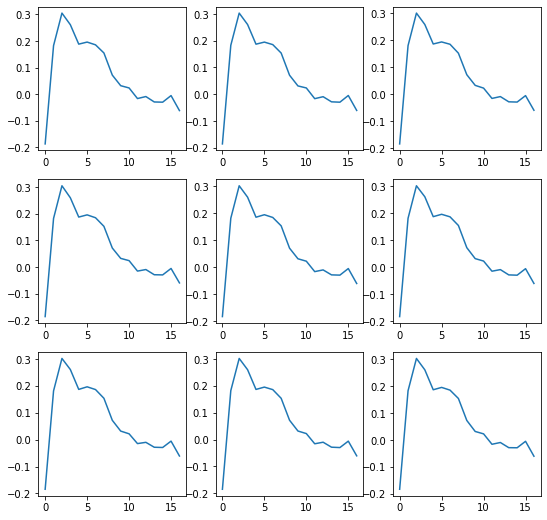

epoch-950; D_loss: 1.3574907779693604; G_loss: 0.7460519075393677


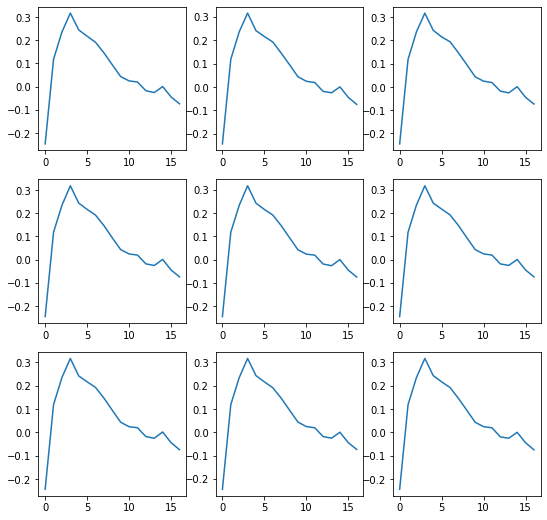

In [13]:
generator = run_train(dataloader, \
          latent_dim=LATENT_DIM, \
          sample_size=len(new_data[0]), \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE, \
          device=DEVICE)

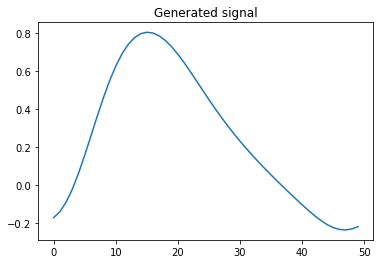

In [21]:
signal = generate_new_signal(generator, device='cuda')
result = [0] * SAMPLE_SIZE
for j in range(len(gaussians)):
    result += signal[j] * gaussians[j]
plt.title("Generated signal")
plt.plot(result)
plt.show()